In [55]:
# Load the Pandas library to read experimental data from the Marionette paper [1]
import pandas as pd
# Import pacti PolyhedralContract class to read contracts
from pacti.contracts import PolyhedralIoContract
from pacti.iocontract.iocontract import Var
from synbio_functions import create_sensor_contracts
from load_data import load_data
# Import matplotlib for plotting
import matplotlib.pyplot as plt
# Import Python numpy
import numpy as np
import re

# Read the data from the paper using the CSV file "marionette_data.csv"
df = pd.read_csv("data/marionette_data_with_std.csv", delimiter=",", engine="python")

# Add the new "std" column with random values between 0.1 and 0.3
df['std'] = np.random.uniform(0.7, 0.71, len(df))

# Write the updated DataFrame to a new CSV file
df.to_csv('data/marionette_data_with_std.csv', index=False)
# Load Eric data
all_absolute_data = load_data("absolute")
all_normalized_data = load_data("normalized")
# Create all sensor contracts:
sensor_names = [str(i) for i in df["Inducer"]]
sensor_library = {}
sensor_library_params = {}
for sensor in sensor_names:
    sensor_params = {}
    yleak_s = df.loc[df["Inducer"] == sensor]["ymin (RPUx10-3)"].values[0]
    yleak_s = yleak_s * 1e-3
    s_start = df.loc[df["Inducer"] == sensor]["start"].values[0]
    s_K = df.loc[df["Inducer"] == sensor]["K (µM)"].values[0]
    ymax_s = df.loc[df["Inducer"] == sensor]["ymax Linear"].values[0]
    ymax_sat = df.loc[df["Inducer"] == sensor]["ymax (RPU)"].values[0]
    std = df.loc[df["Inducer"] == sensor]["std"].values[0]
    sexp_start = s_start
    sexp_K = 100*s_K
    if sensor in all_normalized_data:
        curr_data = all_normalized_data[sensor]
        # Extract numerical part from column names and convert them to integers
        column_numbers = [float(re.match(r'(\d+\.?\d*)', col).group()) for col in curr_data.columns if re.match(r'(\d+\.?\d*)', col)]
        sorted_column_numbers = sorted(column_numbers)
        sexp_K = max(column_numbers)
        sexp_start = min(column_numbers)
        sexp_start = sorted_column_numbers[1]
        s_K = sorted_column_numbers[2]
    # if sensor == "Sal":
    #     s_start = 25*s_start
    #     K = 8*s_K
#         sexp_K = 40*s_K
    if sensor == "aTc":
        s_start = 4*s_start
        sexp_K = 100*s_K
        s_K = s_K
    if sensor == "OHC14":
        s_K = s_K
    sensor_params = {"leak": yleak_s, "start": s_start,
                     "K": s_K, "ymax": ymax_s, "std":std, "ymax_sat":ymax_sat, 
                     "exp_start":sexp_start, "exp_K":sexp_K}
    s_output = "dCas9"
    contract_s_0, contract_s_lin, contract_s_max = create_sensor_contracts(
        sensor_input=sensor, output="xRFP", start=s_start, K=s_K,
        ymax_lin=ymax_s, yleak=yleak_s, std=std, ymax_sat = ymax_sat, final_K = sexp_K,
    )
    sensor_library[sensor] = [contract_s_0, contract_s_lin, contract_s_max]
    sensor_library_params[sensor] = sensor_params

# Create available sensor contracts:
sensor_contracts = {}

contract_DAPG_off, contract_DAPG_lin, contract_DAPG_sat = create_sensor_contracts(
    sensor_input="DAPG", output="xRFP", start=sensor_library_params["DAPG"]["start"],
    K=sensor_library_params["DAPG"]["K"],
    ymax_lin=sensor_library_params["DAPG"]["ymax"], yleak=sensor_library_params["DAPG"]["leak"],
    ymax_sat=sensor_library_params["DAPG"]["ymax_sat"],
    std=sensor_library_params["DAPG"]["std"], final_K = sensor_library_params["DAPG"]["exp_K"],
)
#sensor_contracts["DAPG"] = [contract_DAPG_off, contract_DAPG_lin, contract_DAPG_sat]
sensor_contracts["DAPG"] = [contract_DAPG_off, contract_DAPG_sat]


contract_Van_off, contract_Van_lin, contract_Van_sat = create_sensor_contracts(
    sensor_input="Van", output="xRFP", start=sensor_library_params["Van"]["start"],
    K=sensor_library_params["Van"]["K"],
    ymax_lin=sensor_library_params["Van"]["ymax"], yleak=sensor_library_params["Van"]["leak"],
    ymax_sat=sensor_library_params["Van"]["ymax_sat"],
    std=sensor_library_params["Van"]["std"], final_K = sensor_library_params["Van"]["exp_K"],
)
sensor_contracts["Van"] = [contract_Van_off, contract_Van_sat]


contract_OC6_off, contract_OC6_lin, contract_OC6_sat = create_sensor_contracts(
    sensor_input="OC6", output="xRFP", start=sensor_library_params["OC6"]["start"],
    K=sensor_library_params["OC6"]["K"],
    ymax_lin=sensor_library_params["OC6"]["ymax"], yleak=sensor_library_params["OC6"]["leak"],
    ymax_sat=sensor_library_params["OC6"]["ymax_sat"],
    std=sensor_library_params["OC6"]["std"], final_K = sensor_library_params["OC6"]["exp_K"],
)
sensor_contracts["OC6"] = [contract_OC6_off, contract_OC6_sat]


def reflect(low_high_contract : list[PolyhedralIoContract], newoutput_name):
    from pacti.terms.polyhedra import PolyhedralTerm, PolyhedralTermList
    # the upper bound of the off region
    invar = low_high_contract[0].inputvars[0]
    outvar = low_high_contract[0].outputvars[0]
    newoutvar = Var(newoutput_name)
    x_off_u = low_high_contract[0].get_variable_bounds(str(invar))[1]
    # the lower bound of the high region
    x_on_l = low_high_contract[1].get_variable_bounds(str(invar))[0]
    # new upper guarantees
    new_guarantees = []
    term : PolyhedralTerm
    for term in low_high_contract[0].g.terms:
        y_val = (term.constant - term.get_coefficient(invar)*x_off_u)/term.get_coefficient(outvar)
        new_term = PolyhedralTerm(
            variables={invar:-term.get_coefficient(invar), newoutvar:term.get_coefficient(outvar)},
            constant=-term.get_coefficient(invar) * x_on_l + term.get_coefficient(outvar) * y_val 
            )
        new_guarantees.append(new_term)
    upper_contract = PolyhedralIoContract(
        input_vars=[invar],
        output_vars=[newoutvar],
        assumptions=low_high_contract[1].a,
        guarantees=PolyhedralTermList(new_guarantees))
    # now get the new lower contract
    new_guarantees = []
    term : PolyhedralTerm
    for term in low_high_contract[1].g.terms:
        y_val = (term.constant - term.get_coefficient(invar)*x_on_l)/term.get_coefficient(outvar)
        new_term = PolyhedralTerm(
            variables={invar:-term.get_coefficient(invar), newoutvar:term.get_coefficient(outvar)},
            constant=-term.get_coefficient(invar) * x_off_u + term.get_coefficient(outvar) * y_val 
            )
        new_guarantees.append(new_term)
    lower_contract = PolyhedralIoContract(
        input_vars=[invar],
        output_vars=[newoutvar],
        assumptions=low_high_contract[0].a,
        guarantees=PolyhedralTermList(new_guarantees))
    
    return [lower_contract, upper_contract]
    

lux_contracts = reflect(sensor_contracts['OC6'],"LuxB")
vancc_contracts = reflect(sensor_contracts['Van'],"VanCC")
PhiF_contracts = reflect(sensor_contracts['DAPG'],"PhiF")
        



InVars: [OC6]
OutVars:[xRFP]
A: [
  -OC6 <= -2
  OC6 <= 20
]
G: [
  -0.07566 OC6 + xRFP <= 0.6998
  0.01323 OC6 - xRFP <= -0.1224
]


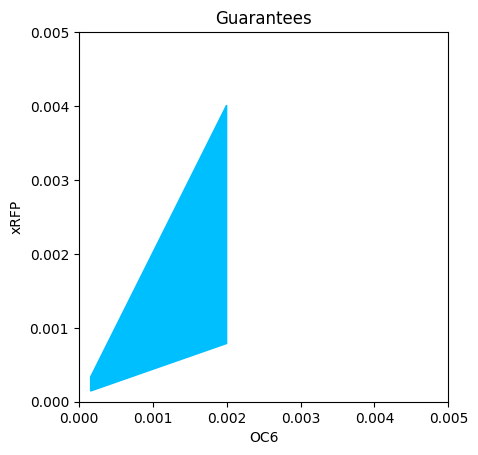

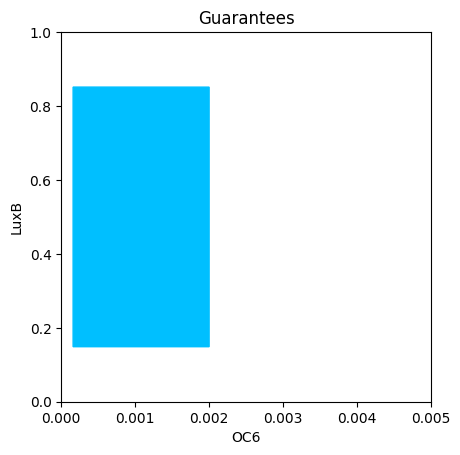

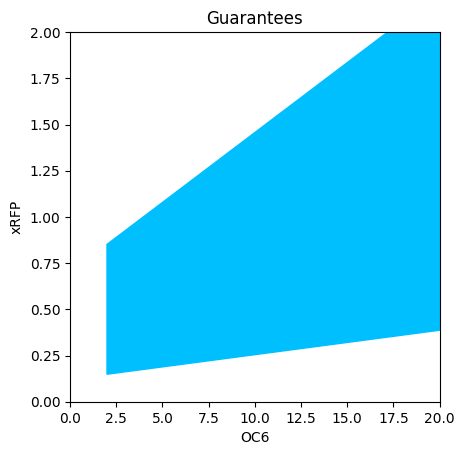

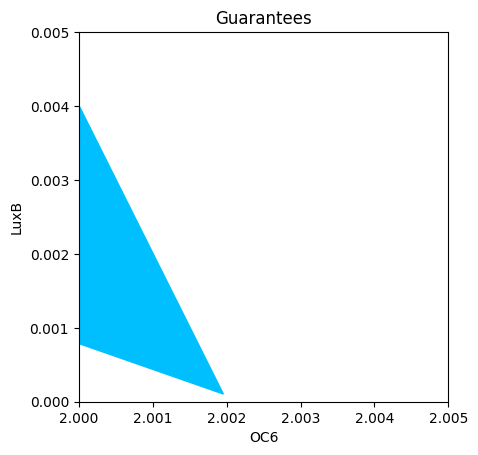

In [54]:
from pacti.utils.plots import plot_guarantees

oc6_low : PolyhedralIoContract = sensor_contracts['OC6'][0]
oc6_high : PolyhedralIoContract = sensor_contracts['OC6'][1]
print(oc6_high)
ivar= oc6_low.inputvars[0]

_=plot_guarantees(contract=oc6_low,
                x_var=ivar,
                y_var=oc6_low.outputvars[0],
                var_values={},
                x_lims=(0,0.005),
                y_lims=(0,0.005))

_=plot_guarantees(contract=lux_contracts[0],
                x_var=ivar,
                y_var=lux_contracts[0].outputvars[0],
                var_values={},
                x_lims=(0,0.005),
                y_lims=(0,1))

_=plot_guarantees(contract=oc6_high,
                x_var=ivar,
                y_var=oc6_high.outputvars[0],
                var_values={},
                x_lims=(0,20),
                y_lims=(0,2))


_=plot_guarantees(contract=lux_contracts[1],
                x_var=ivar,
                y_var=lux_contracts[1].outputvars[0],
                var_values={},
                x_lims=(2,2.005),
                y_lims=(0,0.005))




